# The Variational Quantum Eigensolver

VQE one, two, three, four

 One:   One core concept: Variational principle <br/>
 Two:   Two subroutine: Quantum and Classical <br/>
Three:  Three steps: Ansatz preparation, measure expectation and optimization <br/>
And........  For Success!

In [1]:
from qiskit import version
version._get_qiskit_versions()

{'qiskit': '0.11.0',
 'qiskit-terra': '0.8.2',
 'qiskit-ignis': '0.1.1',
 'qiskit-aer': '0.2.3',
 'qiskit-ibmq-provider': '0.3.0',
 'qiskit-aqua': '0.5.2'}

## VQE in nutshell: eigenvalue of pauli Z matrix


#### Import package

In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import BasicAer, execute
import numpy as np

### Step 1: Ansatz preparation

Review of Rotation gates:

#### Rotation around Y-axis

$$
R_y(\theta) =
\begin{pmatrix}
\cos(\theta/2) & - \sin(\theta/2)\\
\sin(\theta/2) & \cos(\theta/2).
\end{pmatrix} =u3(\theta,0,0)
$$

In [3]:
qr = QuantumRegister(1, 'q')

def vqe_ansatz(theta):
    var_circ= QuantumCircuit(qr)
    var_circ.ry(theta,qr)
    return var_circ

#### Trial wave function (ansatz)

$R_y(\theta) | \psi_0 \rangle = \begin{bmatrix}
\cos(\theta/2)\\ \sin(\theta/2)
\end{bmatrix}$

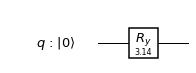

In [4]:
%matplotlib inline 
vqe_ansatz(3.14).draw(output='mpl')

### Step 2: Measure Expectation value (qasm backend)

Expectation value of $ \langle \psi_0 | H | \psi_0 \rangle =\langle \psi_0 | Z | \psi_0 \rangle$

$\begin{bmatrix}
\cos(\frac{\theta}{2}) & \sin(\frac{\theta}{2})
\end{bmatrix}
\begin{bmatrix}
1 & 0\\ 
0 & -1
\end{bmatrix}
\begin{bmatrix}
\cos(\theta/2)\\ \sin(\theta/2)
\end{bmatrix} =\cos^2(\frac{\theta}{2})-\sin^2(\frac{\theta}{2})$

In [5]:
### Select simulator
QC_simulator = BasicAer.get_backend('qasm_simulator')

# Define number of measurments shots
sample_shots=1000

cr = ClassicalRegister(1, 'c')
def expval(parameter):
    
    # Call ansatz
    circ_in=vqe_ansatz(parameter)
    
    # Measure in z basis
    meas = QuantumCircuit(qr, cr)
    meas.barrier(qr)
    meas.measure(qr,cr)
    vqe=circ_in+meas
    
    # Compile and execute
    job_qasm = execute(vqe, QC_simulator,shots=sample_shots)
    result_sim = job_qasm.result().get_counts()
    
    # Calculate expectation
    P_0=result_sim.get('0',0)/sample_shots
    P_1=result_sim.get('1',0)/sample_shots
    vqe_ans=P_0-P_1
    
    return vqe_ans

#### Test yout expectation value

In [6]:
test_expval=expval(0.5)
print("Expectation value : {}".format(test_expval))

Expectation value : 0.8899999999999999


### Step 3: Optimization

$$E(\boldsymbol\theta)\equiv  \langle H \rangle = \langle \psi(\boldsymbol\theta)| H |\psi(\boldsymbol\theta)\rangle \ge E_0 = \langle \psi_0 | H | \psi_0 \rangle,$$ 


Since in this case, we have only one parameter $\theta$, we can calculate the expectation value for $\theta \in [0,2\pi]$

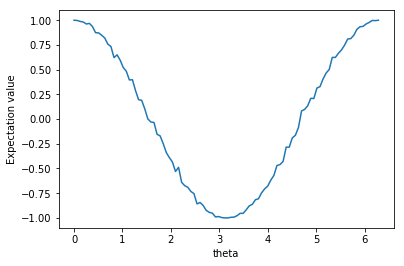

In [7]:
theta_range = np.linspace(0.0, 2 * np.pi, 100)
vqe_result=[expval(params) for params in theta_range]

import matplotlib.pyplot as plt
plt.xlabel('theta')
plt.ylabel('Expectation value')
plt.plot(theta_range, vqe_result)
plt.show()

In [8]:
print("The lowest eigenvalue: {0} \t corresponding parameters: {1}".format(min(vqe_result),theta_range[vqe_result.index(min(vqe_result))]))

The lowest eigenvalue: -1.0 	 corresponding parameters: 3.1098593944626236


#### Optimizer 

In [9]:
from scipy.optimize import minimize
initial_guess=[0]

ans=minimize(expval,initial_guess,method='COBYLA')
ans

     fun: -1.0
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 15
  status: 1
 success: True
       x: array([3.125])

## VQE with statevector simulator

In [10]:
### Select simulator
QC_statevector = BasicAer.get_backend('statevector_simulator')

def ext_expval(parameter):
    # Call ansatz
    circ_ext=vqe_ansatz(parameter)
    
    # Compile and execute
    job_statevector = execute(circ_ext, QC_statevector)

    # Calculate expectation
    Pext_0=job_statevector.result().get_statevector()[0]**2
    Pext_1=job_statevector.result().get_statevector()[1]**2
    vqe_ans=Pext_0-Pext_1
    return vqe_ans.real
    

In [11]:
from scipy.optimize import minimize
initial_guess=[0]
ans=minimize(ext_expval,initial_guess,method='COBYLA')
ans

     fun: -0.9999999940694247
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 23
  status: 1
 success: True
       x: array([3.14170156])

## Now package comes in

In [12]:
from qiskit.aqua import Operator
from qiskit.aqua.components.initial_states import Zero
from qiskit.aqua.algorithms.adaptive import VQE
from qiskit.aqua.algorithms.classical import ExactEigensolver
from qiskit.aqua.components.variational_forms import RY, RYRZ, swaprz
from qiskit.aqua.components.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit.aqua import QuantumInstance, aqua_globals

## DIY problems: How to find the lowest eigenvalue of given matrix?

### $M=\begin{bmatrix}
−0.2524859 & 0.18121 \\ 
0.18121 & −1.8318639
\end{bmatrix}=-1.0421749I+ 0.789689Z+ 0.181210X.$

#### toolkits 
(There may be some bugs)

In [1]:
import numpy as np

X = np.matrix([[0, 1],[1,0]])
Y = np.matrix([[0, -1j],[1j, 0]])
Z = np.matrix([[1,0],[0,-1]])
I = np.matrix([[1,0],[0,1]])

pauli = {'I':I, 'X':X, 'Y': Y, 'Z':  Z}

def construct_basis(label): 
     ans = pauli[label[0]] 
     for i in label[1:]: 
         ans = np.kron(ans, pauli[i]) 
     return ans 

def get_ope(pauli_dict): 
     ans = 0 
     for term in pauli_dict['paulis']: 
         ans +=  ((term['coeff']['real']+1j*term['coeff']['imag'])*construct_basis(term['label'])) 
     return ans 

In [13]:
# Input the Qubit_Operator (pauli strings form)
pauli_dict = {
    'paulis': [{"coeff": {"imag": 0.0, "real": -1.0421749}, "label": "I"},
              {"coeff": {"imag": 0.0, "real": 0.789689}, "label": "Z"},
              {"coeff": {"imag": 0.0, "real": 0.181210}, "label": "X"}
              ]
}
qubit_op = Operator.load_from_dict(pauli_dict)
print(qubit_op.print_operators())

I	(-1.0421749+0j)
Z	(0.789689+0j)
X	(0.18121+0j)



In [14]:
# Set the optimizer and simulator
QC_statevector = BasicAer.get_backend('statevector_simulator')
max_eval=100
cobyla=COBYLA(maxiter=max_eval)
quantum_instance=QuantumInstance(backend=QC_statevector)

# Define the ansatz
num_qubits = qubit_op.num_qubits
init_state = Zero(num_qubits)
var_form = RY(num_qubits, initial_state=init_state,depth=1)

# Run the VQE
vqe = VQE(qubit_op, var_form, cobyla, 'matrix',initial_point=np.zeros(var_form.num_parameters))

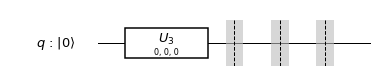

In [15]:
# See the ansatz circuit
var_form.construct_circuit(parameters=np.zeros(var_form.num_parameters)).draw(output='mpl')

## Run

In [16]:
results = vqe.run(quantum_instance)

In [17]:
results

{'num_optimizer_evals': 23,
 'min_val': -1.8523883148401405,
 'opt_params': array([3.3670875]),
 'eval_time': 0.0820002555847168,
 'eval_count': 23,
 'energy': -1.8523883148401405,
 'eigvals': array([-1.85238831]),
 'min_vector': array([-0.1125087 +0.j,  0.99365074+0.j]),
 'eigvecs': array([[-0.1125087 +0.j,  0.99365074+0.j]])}